<h1 style="text-align: center;">Projet : Optimisez la gestion des données d'une boutique avec R ou Python
</h1><font></font>

***


<img src="bp.png" width="500" height="1024" align: center/>


<h2 style="text-align: center;">Parnasse Jérôme le 21/11/2022</h2><font></font>






<h2>Sommaire</h2><font></font>

* [ERP](#ERP)
* [LIAISON](#LIAISON)
* [JOINTURE ERP/LIAISON](#JOINTURE_ERP_LIAISON)
* [WEB](#WEB)
* [JOINTURE WEB/ERP/LIAISON](#JOINTURE_WEB_ERP_LIAISON)
* [VISUALISATION DES DONNEES](#VISUALISATION_DES_DONNEES)


### Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

### Importation des jeux de données

In [2]:
# fichier de gestion de l'entreprise
erp = pd.read_excel("erp.xlsx")

# Fichier de correspondance entre les deux bases
liaison = pd.read_excel("liaison.xlsx")

# fichier de vente en ligne
web = pd.read_excel("web.xlsx")



### Fonctions personnalisées

In [3]:
def df_infos(df):
    """
    Renvoie plusieurs information concernant le dataframe
    - Les 5 premiers lignes
    - Le nombre de ligne et colonne
    - Génére des statistiques descriptives
    - Affiche le type d'index et les colonnes, les valeurs non nulles et l'utilisation de la mémoire.    
    """
    print('\033[1m'+'\n Visualisation de table :'+"\033[0m",'\n', df.head(5),'\n')    
    print('\033[1m'+'\n Nombre de ligne et de colonne '+"\033[0m",'\n', df.shape,'\n')    
    print('\033[1m'+'\n Test de valeur aberrante :'+"\033[0m",'\n', df.describe(),'\n')    
    print('\033[1m'+'\n Valeur non null et Type :'+"\033[0m",'\n', df.info(),'\n')    
    

    
def df_unicité(df):
    """
    Renvoie pour chaque colonne du dataframe :
    -Le nombre de valeur unique
    -La somme des doublons
    -La somme des valeurs manquante
    -Vérifie si une colonne est cadidate à uné clé primaire
    
    """
    """affectation de la liste des noms de colonnes du dataframe dans une variable"""
    df_list = list(df)    
    for i in df_list:
        
        df_unique = len(df[i].unique())        
        df_total_doublon = df.duplicated([i]).sum()        
        df_total_null = df[i].isnull().sum()
        
        if df_total_doublon == 0 and df_total_null == 0 :            
            print("Cette colonne peut etre candidate à une clé primaire")
        
        else :
            print("Cette colonne ne peut etre candidate à une clé primaire")
            
        print('Pour la colonne','\033[1m'+i+"\033[0m")        
        print('Le nombre de valeur unique est de :', df_unique)        
        print('Le nombre total de doublon est de :', df_total_doublon)        
        print('Le nombre de donnée manquante est de :', df_total_null)        
        print('\n')
       
    
def detect_outlier(df):
    """
    Fonction qui permet de trouver des valeurs aberrante 
    Afficher tout point de données situé à plus de 1,5 IQR en dessous du premier quartile (Q 1 ) 
    -ou au-dessus du troisième quartile (Q 3 ) dans un ensemble de données.
    
    A partir du dataframe :
     
    - Trouve la valeur q1(1er quartile) et q3 (3ème quartile)
    - Calculer l'ecart interquartile
    - Trouve les limites inférieur et supérieur
    - Calculer et affchier le nombre outliers
    
    """
    q1, q3 = df.quantile([.25, .75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    print('\033[1m'+'Le premier quartile est de:', q1)
    print ('Le troisième quartile est de:', q3)
    print("Ecart interquartile :", iqr)
    print("limite basse :", np.round((lower_bound), 2))
    print("limite haute:", np.round((upper_bound), 2))
    
    outliers = [x for x in df 
                if x <= lower_bound or
                x >= upper_bound]
    
    print('Le nombre outliers est de :', len(outliers))
    
    return outliers


def detection_outliers_zscore(df, col, SEUIL = 2):
    """
    Fonction qui permet de trouver des valeurs aberrante et d'appliquer un seuil
    
    Attrs:
    - df: le nom du dataframe.
    - col : la colonne pour aplliquer le calcul
    
    """
    moyenne = np.mean(df[col])
    ecart_type = np.std(df[col])
    outliers = [x for x in df[col] 
                if (np.abs((x-moyenne)/ecart_type)) > SEUIL]
    print('Thresold de :',SEUIL)
    print('Les outliers sont :', outliers,'\n')
    print('Le nombre de outliers est de :', len(outliers))
   

<h2 style="text-align: center;">*** Préparation des données ***
</h2><font></font>



### Exploration du fichier erp
<a name="ERP"></a>


#### Fichier qui contient :
- Les références produit 
- Prix de vente
- La quantité de produit en stock
- Etat du stock

**Lecture du fichier**
- Charger le fichier.  
- Voir les 5 premières lignes du dataFrame.  
- Obtenir le nombre de lignes et le nombre de colonnes. 
- Voir les statistiques diverses (moyenne, maximum, minimum, etc.) du dataFrame .   
- Obtenir les détails essentiels sur notre dataFrame.  



In [4]:
#information de la table
df_infos(erp)


 Visualisation de table : 
    product_id  onsale_web  price  stock_quantity stock_status
0        3847           1   24.2               0   outofstock
1        3849           1   34.3               0   outofstock
2        3850           1   20.8               0   outofstock
3        4032           1   14.1               0   outofstock
4        4039           1   46.0               0   outofstock 


 Nombre de ligne et de colonne  
 (825, 5) 


 Test de valeur aberrante : 
         product_id  onsale_web       price  stock_quantity
count   825.000000  825.000000  825.000000      825.000000
mean   5162.597576    0.869091   32.415636       26.496970
std     902.644635    0.337506   26.795849       45.892422
min    3847.000000    0.000000    5.200000        0.000000
25%    4348.000000    1.000000   14.600000        1.000000
50%    4907.000000    1.000000   24.400000       11.000000
75%    5805.000000    1.000000   42.000000       34.000000
max    7338.000000    1.000000  225.000000      


**1.1.2). Unicité par colonne**
- Determine si la colonne peut etre une clé primaire
- Nombre de valeur unique 
- Nombre de doublon 
- Nombre de valeur manquante


In [5]:
#Test d'unicité des colonnes concernant les valeurs en doublons et les données manquante
df_unicité(erp)

Cette colonne peut etre candidate à une clé primaire
Pour la colonne product_id
Le nombre de valeur unique est de : 825
Le nombre total de doublon est de : 0
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne onsale_web
Le nombre de valeur unique est de : 2
Le nombre total de doublon est de : 823
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne price
Le nombre de valeur unique est de : 381
Le nombre total de doublon est de : 444
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne stock_quantity
Le nombre de valeur unique est de : 128
Le nombre total de doublon est de : 697
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne stock_status
Le nombre de valeur unique est de : 2
Le nombre total de doublon est de : 823
Le nombre de donnée m

Après le test d'unicité dans la table erp, j'ai constaté que la colonne produit_id 
est éligible en tant que clé primaire


<h2 style="text-align: center;">*** Préparation des données ***</h2><font></font>

### Exploration du fichier de liaison
<a name="LIAISON"></a>

In [6]:
#information de la table
df_infos(liaison)


 Visualisation de table : 
    product_id id_web
0        3847  15298
1        3849  15296
2        3850  15300
3        4032  19814
4        4039  19815 


 Nombre de ligne et de colonne  
 (825, 2) 


 Test de valeur aberrante : 
         product_id
count   825.000000
mean   5162.597576
std     902.644635
min    3847.000000
25%    4348.000000
50%    4907.000000
75%    5805.000000
max    7338.000000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB

 Valeur non null et Type : 
 None 



In [7]:
#Test d'unicité des colonnes concernant les valeurs en doublons et les données manquante
df_unicité(liaison)

Cette colonne peut etre candidate à une clé primaire
Pour la colonne product_id
Le nombre de valeur unique est de : 825
Le nombre total de doublon est de : 0
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne id_web
Le nombre de valeur unique est de : 735
Le nombre total de doublon est de : 90
Le nombre de donnée manquante est de : 91




***Les deux clés de nos bases sont uniques***
product_id de la table erp et product_id de la table liaison ne comportent ni de doublons ni de valeurs manquante, a ce stade , nous pouvons proceder  à la jointure

***La colonne id_web***
On trouve 91 valeurs manquantes pour l' 'id_web' comparé au 'product_id'.
Peut-être parce que tout les produits ne sont pas vendus sur internet.

### Jointure entre erp et liaison
<a name="JOINTURE_ERP_LIAISON"></a>

#### 1ère demande
un export de l’ERP contenant les références produit, leur prix de vente et leur état de stock, et un export d’une table de l’outil de CMS contenant les informations des produits commercialisés en ligne (nom, description, nombre de ventes...).


Cette jointure permet d’établir le lien entre la référence du produit dans l’ERP (product_id) 
et la référence du même produit dans la base de la boutique en ligne(CMS). 

In [8]:
#jointure interne sur le critere product-id: On procède à une jointure interne entre les deux fichiers afin d'avoir une correpondance avec une colonne du fichier web
erp_liaison = pd.merge(liaison, erp, on= ['product_id'])
erp_liaison.head(10)

,product_id,id_web,onsale_web,price,stock_quantity,stock_status
0,3847,15298,1,24.2,0,outofstock
1,3849,15296,1,34.3,0,outofstock
2,3850,15300,1,20.8,0,outofstock
3,4032,19814,1,14.1,0,outofstock
4,4039,19815,1,46.0,0,outofstock
5,4040,15303,1,34.3,0,outofstock
6,4041,14975,1,32.7,15,instock
7,4042,16042,1,31.2,34,instock
8,4043,14980,1,60.0,12,instock
9,4045,16041,1,42.6,66,instock


In [9]:
df_unicité(erp_liaison)

Cette colonne peut etre candidate à une clé primaire
Pour la colonne product_id
Le nombre de valeur unique est de : 825
Le nombre total de doublon est de : 0
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne id_web
Le nombre de valeur unique est de : 735
Le nombre total de doublon est de : 90
Le nombre de donnée manquante est de : 91


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne onsale_web
Le nombre de valeur unique est de : 2
Le nombre total de doublon est de : 823
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne price
Le nombre de valeur unique est de : 381
Le nombre total de doublon est de : 444
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne stock_quantity
Le nombre de valeur unique est de : 128
Le nombre total de doublon est de : 697
Le nombre de donnée manqu

In [10]:
# création d'un fichier de doublons
doublon_id_web = erp_liaison[erp_liaison.duplicated(['id_web'])]
doublon_id_web

,product_id,id_web,onsale_web,price,stock_quantity,stock_status
49,4090,NaN,0,73.0,0,outofstock
50,4092,NaN,0,47.0,0,outofstock
119,4195,NaN,0,14.1,0,outofstock
131,4209,NaN,0,73.5,0,outofstock
151,4233,NaN,0,20.0,0,outofstock
...,...,...,...,...,...,...
817,7196,NaN,0,31.0,55,instock
818,7200,NaN,0,31.0,6,instock
819,7201,NaN,0,31.0,18,instock
820,7203,NaN,0,45.0,30,instock


In [11]:
#nombre de valeurs manquante
doublon_id_web['id_web'].isnull().sum()

90

In [12]:
# supression des doublons

erp_liaison.drop_duplicates(subset ="id_web", keep=False, inplace=True)


In [13]:
#remplie les valeurs manquante par 0
erp_liaison.fillna(0, inplace=True)


In [14]:
print(erp_liaison.isnull().sum())

product_id        0
id_web            0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64


<h2 style="text-align: center;">*** Préparation des données ***</h2><font></font>

### Exploration du fichier web
<a name="WEB"></a>

Fichier 'web' qui contient :

Les informations des produits commercialisés en ligne
(nom, description, nombre de ventes...)

Information sur fichier

In [15]:
df_infos(web)


 Visualisation de table : 
                    sku  virtual  downloadable  rating_count  average_rating  \
0  bon-cadeau-25-euros        0             0             0             0.0   
1                15298        0             0             0             0.0   
2                15296        0             0             0             0.0   
3                15300        0             0             0             0.0   
4                19814        0             0             0             0.0   

   total_sales tax_status  tax_class  post_author           post_date  ...  \
0         10.0    taxable        NaN          1.0 2018-06-01 13:53:46  ...   
1          6.0    taxable        NaN          2.0 2018-02-08 12:58:52  ...   
2          0.0    taxable        NaN          2.0 2018-02-08 13:49:41  ...   
3          0.0    taxable        NaN          2.0 2018-02-08 14:08:36  ...   
4          3.0    taxable        NaN          2.0 2018-02-09 14:01:05  ...   

                           

In [16]:
"""création d'un dataframe contenant Vérification des doublons:
La pluspart des doublons sont dûs au fait que pour chaque produit il y ait une ligne correspondant à la description du produit, et une autre à sa photo.
On garde les lignes de la colonne post-type égale à product pour évité les doublons """

web_temp = pd.DataFrame(web[web.post_type == 'product'])


**Changer le nom de la colonne 'sku' en 'id_web'**

In [17]:
#renommage de la colonne sku en 'id_web'
web_temp.rename({'sku': 'id_web'}, axis=1, inplace=True)
web_temp

,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,16135,0,0,0,0.0,5.0,taxable,NaN,2.0,2020-04-25 13:22:38,...,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
767,15891,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-05-02 14:53:40,...,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
768,15887,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-05-02 15:00:54,...,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
797,13127-1,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-06-09 15:42:04,...,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [18]:
#suppresion de ligne ou bon cadeau 25 euros apparait dans l'index
#web_temp2 = web_temp[web_temp['id_web'] == 'bon-cadeau-25-euros'].index
web_df = web_temp#.drop(web_temp2)
web_df

,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,16135,0,0,0,0.0,5.0,taxable,NaN,2.0,2020-04-25 13:22:38,...,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
767,15891,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-05-02 14:53:40,...,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
768,15887,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-05-02 15:00:54,...,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
797,13127-1,0,0,0,0.0,0.0,taxable,NaN,2.0,2020-06-09 15:42:04,...,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [19]:
df_unicité(web_df)

Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne id_web
Le nombre de valeur unique est de : 715
Le nombre total de doublon est de : 1
Le nombre de donnée manquante est de : 2


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne virtual
Le nombre de valeur unique est de : 1
Le nombre total de doublon est de : 715
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne downloadable
Le nombre de valeur unique est de : 1
Le nombre total de doublon est de : 715
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne rating_count
Le nombre de valeur unique est de : 1
Le nombre total de doublon est de : 715
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne average_rating
Le nombre de valeur unique est de : 1
Le nombre total de doublon est de : 715
Le nombre de donnée ma

In [20]:
#affichage des doublons
web_df[web_df.duplicated(['id_web'], keep=False)]


,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
470,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-07-31 12:07:23,...,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
471,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-08-08 11:23:43,...,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [21]:
#supprimer les doublons
web_df.drop_duplicates(subset ="id_web", keep=False, inplace=True) 

In [22]:
#nombre de valeur en doublon
web_df.duplicated(['id_web']).sum()

0

In [23]:
#remplacer valeur manquant par 0
web_df =web_df.fillna(0)


In [24]:
#afficher le nombre de valeur manquante
web_df.isnull().sum()


id_web                   0
virtual                  0
downloadable             0
rating_count             0
average_rating           0
total_sales              0
tax_status               0
tax_class                0
post_author              0
post_date                0
post_date_gmt            0
post_content             0
post_title               0
post_excerpt             0
post_status              0
comment_status           0
ping_status              0
post_password            0
post_name                0
post_modified            0
post_modified_gmt        0
post_content_filtered    0
post_parent              0
guid                     0
menu_order               0
post_type                0
post_mime_type           0
comment_count            0
dtype: int64

In [25]:
df_unicité(web_df)

Cette colonne peut etre candidate à une clé primaire
Pour la colonne id_web
Le nombre de valeur unique est de : 714
Le nombre total de doublon est de : 0
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne virtual
Le nombre de valeur unique est de : 1
Le nombre total de doublon est de : 713
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne downloadable
Le nombre de valeur unique est de : 1
Le nombre total de doublon est de : 713
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne rating_count
Le nombre de valeur unique est de : 1
Le nombre total de doublon est de : 713
Le nombre de donnée manquante est de : 0


Cette colonne ne peut etre candidate à une clé primaire
Pour la colonne average_rating
Le nombre de valeur unique est de : 1
Le nombre total de doublon est de : 713
Le nombre de donnée manqu

In [26]:
web_df.shape


(714, 28)

### Jointure entre web et erp_liaison
<a name="JOINTURE_WEB_ERP_LIAISON"></a>


In [27]:
""" 
J'ai choisi La fusion "externe" car elle combine toutes les lignes des dataframes gauche et droite avec NaN 
lorsqu'il n'y a pas de valeurs correspondantes dans les lignes.

la méthode indicator est définie sur True afin d'indiquer d'où provient chaque ligne dans les données de fusion 
"""
web_erp = pd.merge(web_df, erp_liaison, on='id_web', how='outer', indicator=True)

In [28]:
#J'affiche le nombre de ligne et colonne
web_erp.shape

(734, 34)

In [29]:
#Affiche le valeur unique dans la colonne _merge
web_erp['_merge'].unique()

['both', 'right_only']
Categories (3, object): ['left_only', 'right_only', 'both']

In [30]:
web_erp.head(5)

,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,menu_order,post_type,post_mime_type,comment_count,product_id,onsale_web,price,stock_quantity,stock_status,_merge
0,bon-cadeau-25-euros,0.0,0.0,0.0,0.0,10.0,taxable,0.0,1.0,2018-06-01 13:53:46,...,0.0,product,0.0,0.0,4954,1,25.0,0,instock,both
1,15298,0.0,0.0,0.0,0.0,6.0,taxable,0.0,2.0,2018-02-08 12:58:52,...,0.0,product,0.0,0.0,3847,1,24.2,0,outofstock,both
2,15296,0.0,0.0,0.0,0.0,0.0,taxable,0.0,2.0,2018-02-08 13:49:41,...,0.0,product,0.0,0.0,3849,1,34.3,0,outofstock,both
3,15300,0.0,0.0,0.0,0.0,0.0,taxable,0.0,2.0,2018-02-08 14:08:36,...,0.0,product,0.0,0.0,3850,1,20.8,0,outofstock,both
4,19814,0.0,0.0,0.0,0.0,3.0,taxable,0.0,2.0,2018-02-09 14:01:05,...,0.0,product,0.0,0.0,4032,1,14.1,0,outofstock,both


In [31]:
#creation du dataframe ayant comme valeur 'both' (commune) entre les deux tables
web_erp=web_erp.loc[web_erp['_merge'] == 'both']

#suppresion de la colonne '_merge'
web_erp=web_erp.drop(columns=['_merge'])



In [32]:
web_erp.head()


,id_web,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,guid,menu_order,post_type,post_mime_type,comment_count,product_id,onsale_web,price,stock_quantity,stock_status
0,bon-cadeau-25-euros,0.0,0.0,0.0,0.0,10.0,taxable,0.0,1.0,2018-06-01 13:53:46,...,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,0.0,4954,1,25.0,0,instock
1,15298,0.0,0.0,0.0,0.0,6.0,taxable,0.0,2.0,2018-02-08 12:58:52,...,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,0.0,3847,1,24.2,0,outofstock
2,15296,0.0,0.0,0.0,0.0,0.0,taxable,0.0,2.0,2018-02-08 13:49:41,...,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,0.0,3849,1,34.3,0,outofstock
3,15300,0.0,0.0,0.0,0.0,0.0,taxable,0.0,2.0,2018-02-08 14:08:36,...,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,0.0,3850,1,20.8,0,outofstock
4,19814,0.0,0.0,0.0,0.0,3.0,taxable,0.0,2.0,2018-02-09 14:01:05,...,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,0.0,4032,1,14.1,0,outofstock


In [33]:
#nombre de doublons dans la colonne 'post_name'
web_erp.duplicated(['post_name']).sum()

0

In [34]:
#creation dataframe ayant pour valeur 1 dans la colonne 'onsale_web'
vente_en_ligne = web_erp.loc[web_erp['onsale_web'] == 1]

In [35]:
#creation d'un dataframe avec l'affiche de colonne personnalisé

chiffre_aff_web_par_produit = vente_en_ligne[['post_name', 'price', 'stock_quantity', 'total_sales', 'onsale_web', 'product_id']]

### Calcul du chiffre d'affaire par produit

#### 2nd demande
une fois le rapprochement effectué, je souhaiterais avoir le chiffre d’affaires par produit, ainsi que le total du chiffre d’affaires réalisé en ligne.

In [36]:
#creation d'une colone chiffre d'affaire par produit + formule
chiffre_aff_web_par_produit['chiffre_affaire_par_produit'] = chiffre_aff_web_par_produit['total_sales'] * chiffre_aff_web_par_produit['price']

In [37]:
chiffre_aff_web_par_produit

,post_name,price,stock_quantity,total_sales,onsale_web,product_id,chiffre_affaire_par_produit
0,bon-cadeau-de-25-euros,25.0,0,10.0,1,4954,250.0
1,pierre-jean-villa-saint-joseph-preface-2018,24.2,0,6.0,1,3847,145.2
2,pierre-jean-villa-saint-joseph-tilde-2017,34.3,0,0.0,1,3849,0.0
3,pierre-jean-villa-croze-hermitage-accroche-coe...,20.8,0,0.0,1,3850,0.0
4,pierre-jean-villa-igp-gamine-2018,14.1,0,3.0,1,4032,42.3
...,...,...,...,...,...,...,...
709,mouthes-le-bihan-aime-chai-2015,8.4,83,5.0,1,6930,42.0
710,camin-larredya-jurancon-sec-la-virada-2018,27.5,15,0.0,1,7023,0.0
711,jamet-cote-rotie-fructus-voluptas-2018,69.0,2,0.0,1,7025,0.0
712,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,54.8,23,0.0,1,7247,0.0


In [38]:
#calcul du chiffre d'affaire total
chiffre_aff_web_total = chiffre_aff_web_par_produit['chiffre_affaire_par_produit'].sum()

In [39]:
chiffre_aff_web_total

70568.6

### Visualisation des données
<a name="VISUALISATION_DES_DONNEES"></a>
#### 3ème demande
Vérifier si il a eu des erreurs de saisie dans certains prix des produits. 

Effectuer une analyse sur cette variable afin de détecter d’éventuelles valeurs aberrantes, de les lister et d’en faire une représentation graphique pour plus de lisibilité.

In [40]:
chiffre_aff_web_par_produit['price'].describe()

count    714.000000
mean      32.493137
std       27.810525
min        5.200000
25%       14.100000
50%       23.550000
75%       42.175000
max      225.000000
Name: price, dtype: float64

In [41]:
#
detection_outliers_zscore(chiffre_aff_web_par_produit,'price')

Thresold de : 2
Les outliers sont : [100.0, 88.4, 225.0, 126.5, 176.0, 108.5, 157.0, 104.0, 109.6, 102.3, 137.0, 217.5, 105.0, 105.0, 112.0, 92.0, 124.8, 175.0, 191.3, 93.0, 122.0, 114.0, 135.0, 105.6, 116.4, 115.0, 121.0, 99.0, 115.0, 121.0] 

Le nombre de outliers est de : 30


In [42]:
#Calcul de l'ecart type de l'echantillon
np.std(chiffre_aff_web_par_produit['price'], ddof=1 )

27.810524922323722

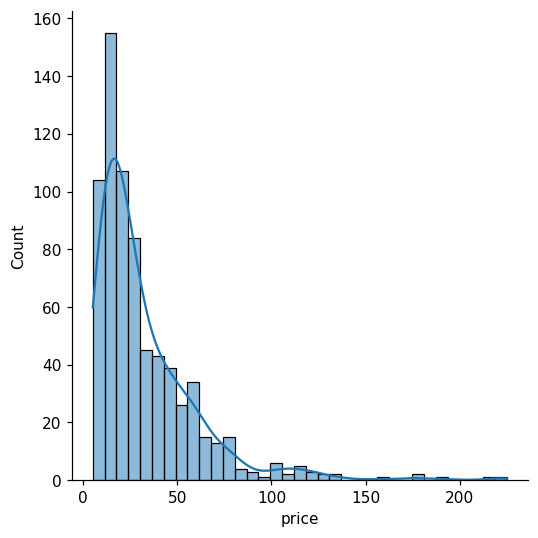

In [43]:
# Histogramme et  Densité de prix
p=sns.displot(chiffre_aff_web_par_produit, x="price", kde = True )
p.fig.set_dpi(110)


Dans ce graphique nous pouvons voir qu'il y a un nombre important de produit

situé dans la fourchette de prix entre 5 à 30€

et que le nombre dércoit lorsque le prix du produit augmente 

In [44]:
prix = chiffre_aff_web_par_produit["price"]

In [45]:
detect_outlier(prix)


Le premier quartile est de: 14.1
Le troisième quartile est de: 42.175000000000004
Ecart interquartile : 28.075000000000003
limite basse : -28.01
limite haute: 84.29
Le nombre outliers est de : 32


[100.0,
 88.4,
 225.0,
 126.5,
 85.6,
 176.0,
 108.5,
 157.0,
 104.0,
 109.6,
 102.3,
 137.0,
 217.5,
 105.0,
 105.0,
 112.0,
 86.8,
 92.0,
 124.8,
 175.0,
 191.3,
 93.0,
 122.0,
 114.0,
 135.0,
 105.6,
 116.4,
 115.0,
 121.0,
 99.0,
 115.0,
 121.0]

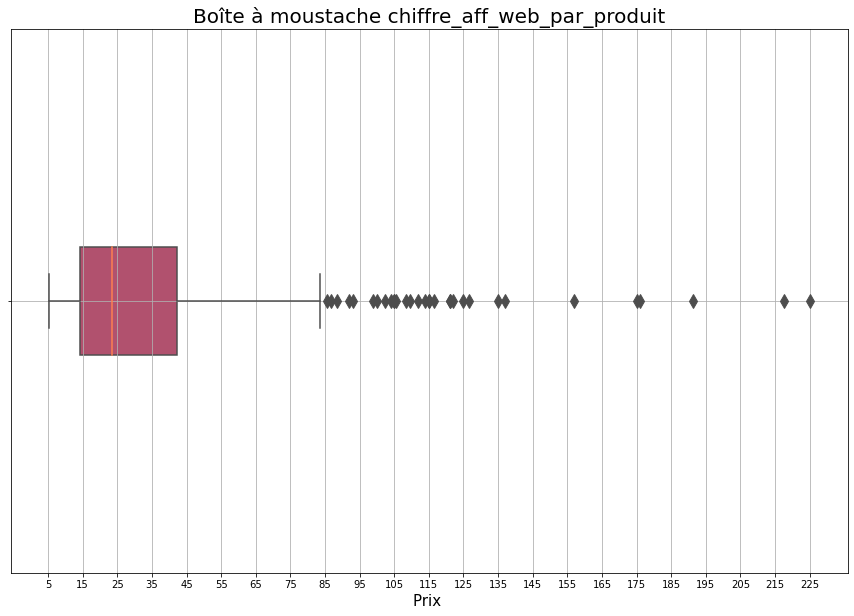

In [46]:
#sns.color_palette("Flare", as_cmap=True)
x=chiffre_aff_web_par_produit["price"].astype(int)
plt.figure(figsize=(15, 10))
sns.boxplot(palette="flare", x=chiffre_aff_web_par_produit["price"], width=0.2,fliersize=10 , medianprops={"color": "coral"},);
plt.xticks(fontsize=10)
plt.xlabel("Prix ", fontsize=15)
plt.title("Boîte à moustache chiffre_aff_web_par_produit", fontsize=20)
plt.xticks(np.arange(min(x), max(x)+1, 10))
plt.grid()
plt.show()


Dans cette boite à moustache nous pouvons constater plusieur chose :

-Que le plus grand nombre de produit se situe entre 5 et 84e

-Que le prix médian est environs 25€

-Que les outliers se situe entre 85 et 225€



In [47]:
vin_supérieur = [x for x in prix if x > 84]
print ("Vins supérieur à 85 €uros:",len(vin_supérieur))
vin_supérieur.sort()
print('Ordre croissant:', vin_supérieur)


Vins supérieur à 85 €uros: 32
Ordre croissant: [85.6, 86.8, 88.4, 92.0, 93.0, 99.0, 100.0, 102.3, 104.0, 105.0, 105.0, 105.6, 108.5, 109.6, 112.0, 114.0, 115.0, 115.0, 116.4, 121.0, 121.0, 122.0, 124.8, 126.5, 135.0, 137.0, 157.0, 175.0, 176.0, 191.3, 217.5, 225.0]


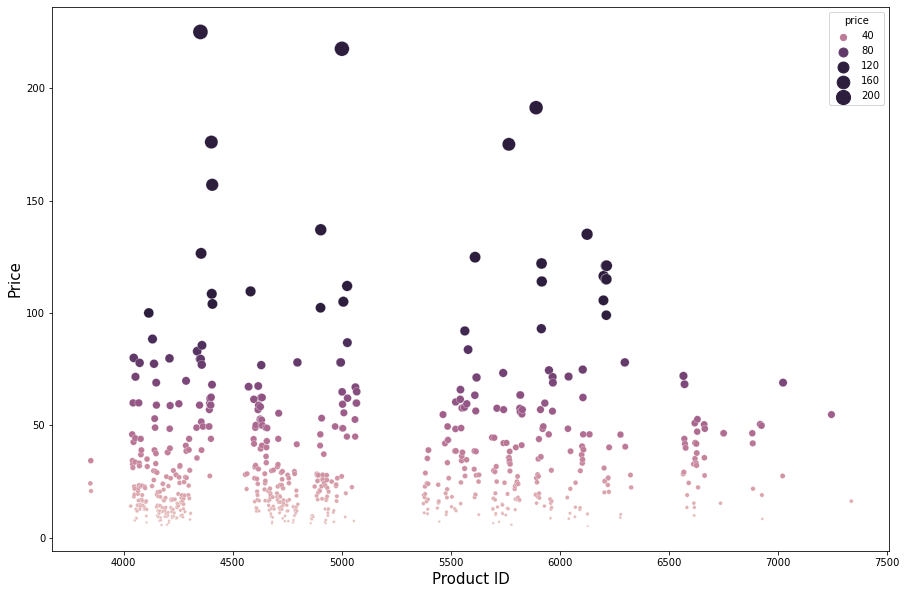

In [48]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=chiffre_aff_web_par_produit, x="product_id", y="price", hue="price", hue_norm=(0, 100),size="price", sizes=(5, 225),)
plt.ylabel("Price",fontsize=15)
plt.xlabel("Product ID",fontsize=15)
plt.show()


Ici nous pouvons observer une concentration des prix inférieur à 75€  représenté par des couleurs de ton claire et de petite taille

A l'inversement les prix les plus élévé de ton sombre, de plus grosse taille

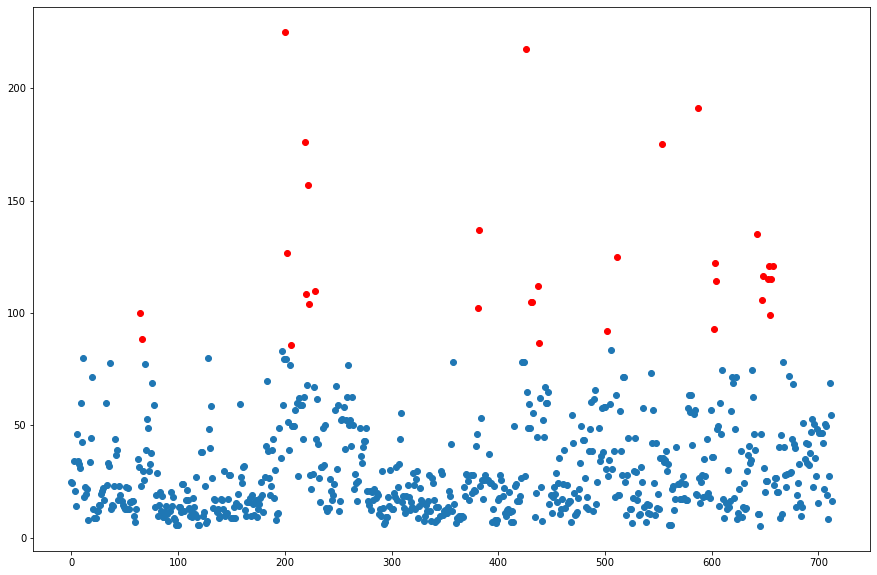

In [49]:
q1, q3 = chiffre_aff_web_par_produit['price'].quantile([.25, .75])
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
plt.figure(figsize=(15,10))
#Creer un variable contenant les nombres entre les limites supérieur ou inférieur
normal = chiffre_aff_web_par_produit[(chiffre_aff_web_par_produit['price'] < upper_bound) 
                                     & (chiffre_aff_web_par_produit['price'] > lower_bound)]

#Creer un variable contenant les nombres en dehors des limites supérieur ou inférieur
outliers = chiffre_aff_web_par_produit[(chiffre_aff_web_par_produit['price'] > upper_bound) 
                                       | (chiffre_aff_web_par_produit['price'] < lower_bound)]

plt.scatter(normal['price'].index, normal['price'].values)
plt.scatter(outliers['price'].index, outliers['price'].values,c='red')
plt.show()

Sur ce graphique on peut distinguer les valeurs aberrante mise en relief par des point de couleur rouge

Celle ci nous informe que cela concerne des valeurs proche de 100€ et supérieur


## Conclusion ##

Les prix qui sont considérés comme "outliers" ou données aberrantes, sont des vins ou spiritueux consommées occasionnellement, elles sont de meilleure qualité ou plus rare.

C'est-à-dire un prix élevé par rapport aux autres produits, les prix sont cohérents avec les prix du marché.

Exemple de site proposant des vins et spiritueux:
https://www.vinatis.com/?prixsup=75&prixinf=230